In [243]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

## Data dictionary

- **survival**	Survival	0 = No, 1 = Yes
- **pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- **sex**	Sex	
- **Age**	Age in years	
- **sibsp**	# of siblings / spouses aboard the Titanic	
- **parch**	# of parents / children aboard the Titanic	
- **ticket**	Ticket number	
- **fare**	Passenger fare	
- **cabin**	Cabin number	
- **embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S =  Southampton

In [244]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [245]:
passenger_id = test['PassengerId']

In [246]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [247]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [248]:
train.shape

(891, 12)

In [249]:
test.shape

(418, 11)

In [250]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [251]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [252]:
full_data = [train, test]

### Explore several categorical features via visualization

In [253]:
def plot_proportion(feature, data):
    survived = data[data['Survived'] == 1][feature].value_counts()
    dead = data[data['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind = 'bar', stacked = True, figsize = (10, 5))

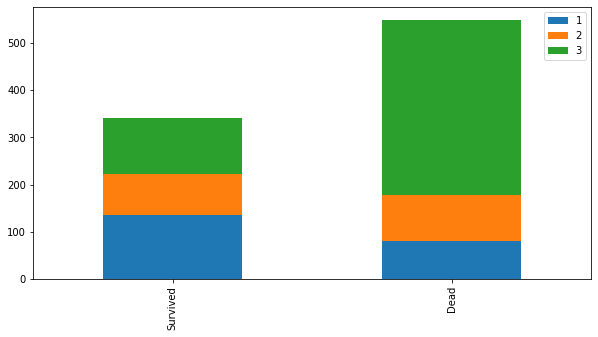

In [254]:
plot_proportion('Pclass', train)

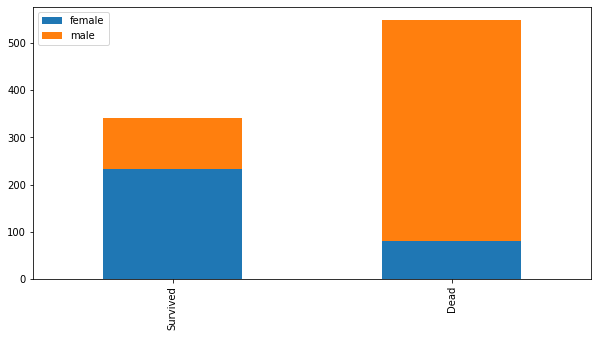

In [255]:
plot_proportion('Sex', train)

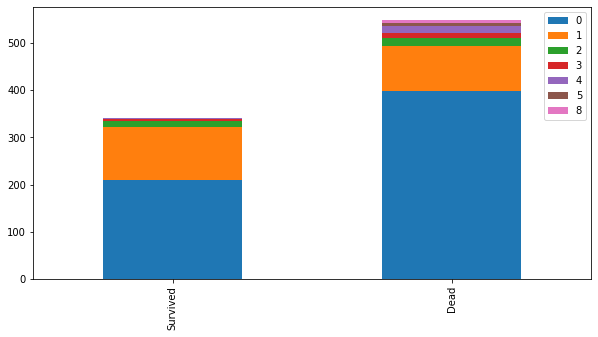

In [256]:
plot_proportion('SibSp', train)

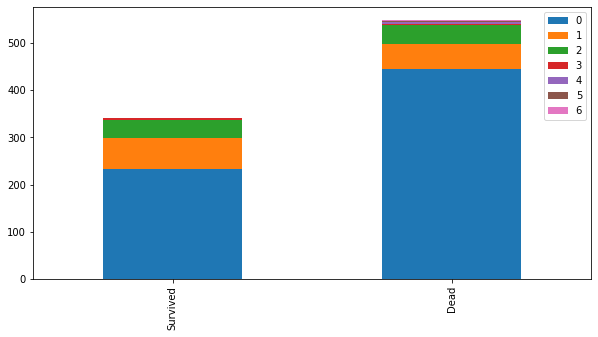

In [257]:
plot_proportion('Parch', train)

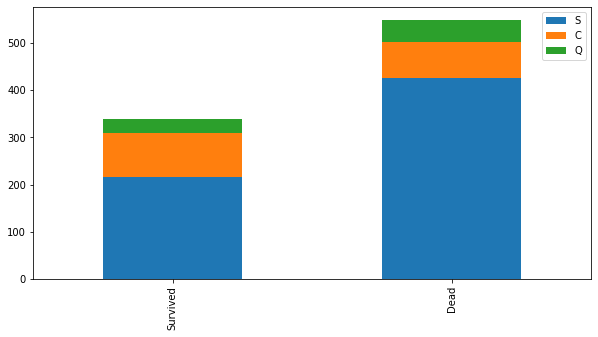

In [258]:
plot_proportion('Embarked', train)

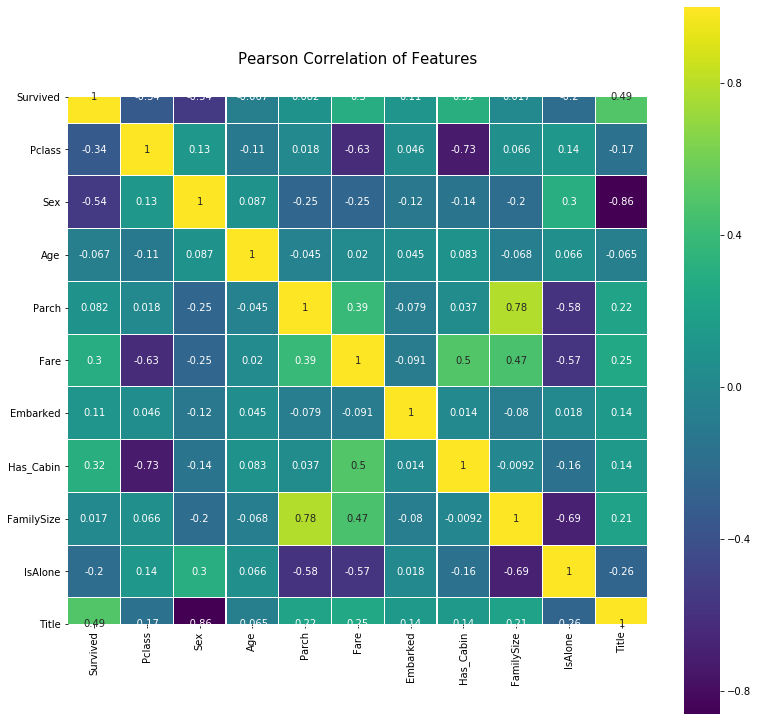

In [286]:
colormap = plt.cm.viridis
plt.figure.Figure(figsize=(12,12))
plt.rcParams['figure.figsize'] = [13, 13]
plt.pyplot.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Clean and preprocess categorical features

In [259]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [260]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [261]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [262]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')


In [263]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [264]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [265]:
import re

In [266]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [267]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [268]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [269]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [270]:
for dataset in full_data:
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [271]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [272]:
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
 

In [273]:
for dataset in full_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] 

In [274]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

### Train, validate and predict using several models 

In [276]:
y_train = train['Survived']

In [277]:
X_train = train.drop(['Survived'], axis = 1)

In [278]:
passenger_ids = passenger_id.to_frame()

In [279]:
from sklearn.model_selection import train_test_split

In [280]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [281]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [282]:
learners = {
    'LogReg': LogisticRegression(random_state=42),
    'NB': GaussianNB(),
    'SVM': SVC()
    }

In [283]:
def train_val_predict(learner, X_train, y_train, X_val, y_val, X_test):
    learner.fit(X_train, y_train)
    val_score = learner.score(X_val,y_val)
    predictions = learner.predict(X_test)
    return val_score, predictions
    

In [284]:
def make_submission(predictions, learner_name):
    survived = pd.DataFrame(data={'Survived': predictions})
    results = pd.merge(passenger_ids, survived, left_index=True, right_index=True)
    results.to_csv(path_or_buf = 'titanic_results_%s.csv' % learner_name, header = True, index = False)     

In [ ]:
for learner_name, learner in learners.items():
    val_score, predictions = train_val_predict(learner, X_train, y_train, X_val, y_val, test)
    make_submission(predictions, learner_name)
    